### This notebook does not use reversible jump when sampling fourier terms. 
It samples all (1, 2, 3, 4, 5, 6). Including Multiplicity 5 which is skipped in CHARMM.
Resulting delta energy is much closer to 0.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

In [2]:
param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')]
param = CharmmParameterSet('../../../../data/charmm_ff/top_all36_cgenff.rtf', 
                           '../../../../data/charmm_ff/par_all36_cgenff.prm')
structure = '../../../structure/butane.psf'
scan = '../../../torsion_scans/MP2_torsion_scan/'
# Print initial guess
print param.dihedral_types[param_to_opt[0]]

# Create a butane scan with torsions on (to compare for difference potential)
butane_scan = ScanSet.parse_psi4_out(scan, structure)
butane_scan.compute_energy(param)
optimized = butane_scan.remove_nonoptimized()
optimized.compute_energy(param)

# Turn off torsion
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0

# Create butane scan with torsions off
optimized_0 = butane_scan.remove_nonoptimized()
optimized_0.compute_energy(param)

<DihedralTypes [<DihedralType; phi_k=0.038, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.032, per=6, phase=180.000,  scee=1.000, scnb=1.000>]>


AttributeError: 'module' object has no attribute 'parse_psi4_out'

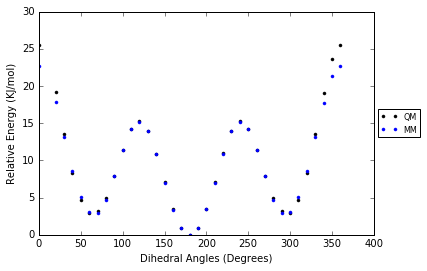

In [4]:
plt.plot(optimized.steps, optimized.qm_energy, 'k.', label='QM')
plt.plot(optimized.steps, optimized.mm_energy, '.', label='MM')
plt.xlabel('Dihedral Angles (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))

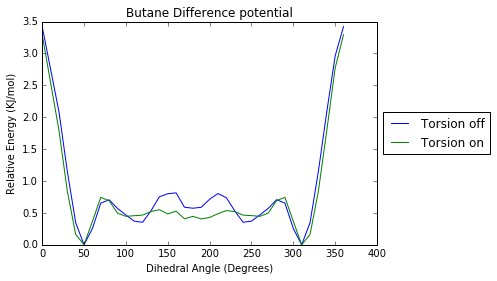

In [7]:
plt.plot(optimized_0.steps, optimized_0.delta_energy-min(optimized_0.delta_energy), label='Torsion off')
plt.plot(optimized.steps, optimized.delta_energy-min(optimized.delta_energy), label='Torsion on')
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Dihedral Angle (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
plt.title('Butane Difference potential')

In [5]:
platform = mm.Platform.getPlatformByName('Reference')
model = Model.TorsionFitModelEliminatePhase(param, optimized_0, platform=platform, 
                                            param_to_opt=param_to_opt, decouple_n=True, sample_n5=True)
sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='butane_n5_decouple_n.db', verbose=5)

In [6]:
sampler.sample(100000)

Assigning step method DiscreteMetropolis to stochastic CG331_CG321_CG321_CG331_multiplicity_bitstring
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_6_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_4_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_3_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_2_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_1_K
Assigning step method Metropolis to stochastic BUTA1_offset
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_5_K
Assigning step method Metropolis to stochastic log_sigma
 [-----------------100%-----------------] 100001 of 100000 complete in 10281.8 sec

In [3]:
db = sqlite_plus.load('butane_n5_decouple_n.db')

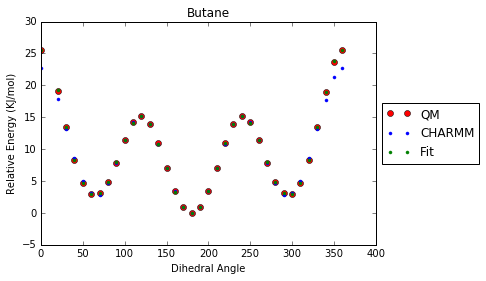

In [12]:
plt.plot(optimized.steps, optimized.qm_energy, 'ro', label='QM')
plt.plot(optimized.steps, optimized.mm_energy, 'b.', label='CHARMM')
plt.plot(optimized.steps, db.mm_energy[-1], 'g.', label='Fit')
plt.title('Butane')
plt.xlabel('Dihedral Angle')
plt.ylabel('Relative Energy (KJ/mol)')
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('Energy_fit.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

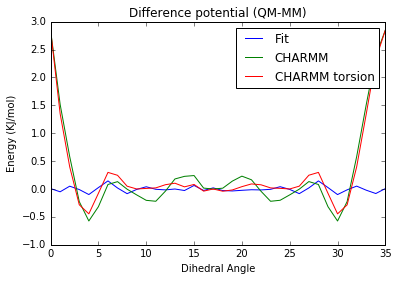

In [34]:
# reparameterize 
param_new = CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
# Turn off torsion
param_new.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param_new.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0

torsion_0 = optimized_0.remove_nonoptimized()
torsion_0.compute_energy(param_new)
plt.plot(optimized_0.delta_energy, label='Fit')
plt.plot(torsion_0.delta_energy, label='CHARMM')
plt.plot(optimized.delta_energy, label='CHARMM torsion')
plt.title('Difference potential (QM-MM)')
plt.xlabel('Dihedral Angle')
plt.ylabel('Energy (KJ/mol)')
plt.legend()
plt.savefig('decouple_n5/diff_pot.pdf')

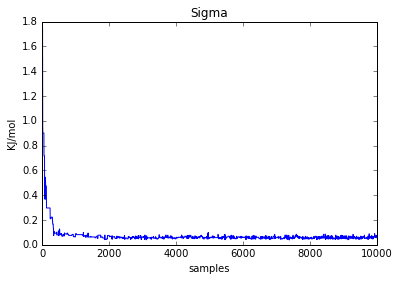

In [22]:
plt.plot(db.sigma[:])
plt.xlabel('samples')
plt.ylabel('KJ/mol')
plt.title('Sigma')
plt.savefig('sigma.pdf')

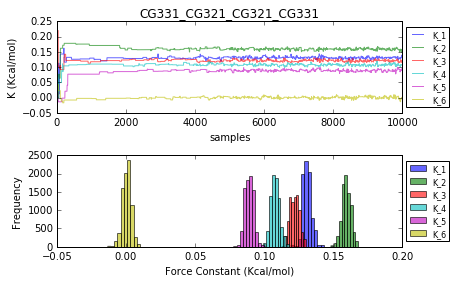

In [4]:
alpha = 0.6
plt.subplot(2, 1, 1)
plt.title('CG331_CG321_CG321_CG331')
plt.plot(db.trace('CG331_CG321_CG321_CG331_1_K')[:], label='K_1', alpha=alpha)
plt.plot(db.trace('CG331_CG321_CG321_CG331_2_K')[:], label='K_2', alpha=alpha)
plt.plot(db.trace('CG331_CG321_CG321_CG331_3_K')[:], label='K_3', alpha=alpha)
plt.plot(db.trace('CG331_CG321_CG321_CG331_4_K')[:], label='K_4', alpha=alpha)
plt.plot(db.trace('CG331_CG321_CG321_CG331_5_K')[:], label='K_5', alpha=alpha)
plt.plot(db.trace('CG331_CG321_CG321_CG331_6_K')[:], label='K_6', alpha=alpha)
plt.xlabel('samples')
plt.ylabel('K (Kcal/mol)')
lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(2, 1, 2)
plt.hist(db.trace('CG331_CG321_CG321_CG331_1_K')[2000:], label='K_1', alpha=alpha)
plt.hist(db.trace('CG331_CG321_CG321_CG331_2_K')[2000:], label='K_2', alpha=alpha)
plt.hist(db.trace('CG331_CG321_CG321_CG331_3_K')[2000:], label='K_3', alpha=alpha)
plt.hist(db.trace('CG331_CG321_CG321_CG331_4_K')[2000:], label='K_4', alpha=alpha)
plt.hist(db.trace('CG331_CG321_CG321_CG331_5_K')[2000:], label='K_5', alpha=alpha)
plt.hist(db.trace('CG331_CG321_CG321_CG331_6_K')[2000:], label='K_6', alpha=alpha)
plt.xlabel('Force Constant (Kcal/mol)')
plt.ylabel('Frequency')
lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('trace_hist.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

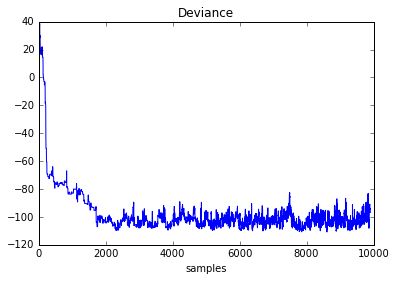

In [5]:
plt.plot(db.deviance[100:])
plt.xlabel('samples')
plt.title('Deviance')
plt.savefig('deviance.pdf')